# Detectron2 onnx export and inference


To gain some speed, especially in embedded devices such as the raspberry pi. Deploying a detectron2 model and 
run the inference on a CPU based backend like the caffe2 onnx backend is a must.

This notebooks describes how to do this. It is based on the [official colab](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

> **Run this notebook inside the detectron2 repository**

# Install detectron2

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.8.0 False


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import time

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data import build_detection_test_loader

import detectron2.data.transforms as T

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [ ]:
# prepare the coco test dataset
!wget http://images.cocodataset.org/zips/val2017.zip
!mkdir -p datasets/coco/
!unzip val2017.zip -d datasets/coco/
./datasets/prepare_for_tests.sh
!mv datasets/coco/annotations/instances_val2017_100.json datasets/coco/annotations/instances_val2017.json

Create a detectron2 config. Choose any model from the [model zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

In [3]:
model_config = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [4]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(model_config))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)
cfg.MODEL.DEVICE = 'cpu'

In [5]:
# Load an image from the coco dataset.
original_image = cv2.imread('datasets/coco/val2017/000000023937.jpg')

In [6]:
# Use the detectron2 `DefaultPredictor` to run inference on this image.
predictor = DefaultPredictor(cfg)
outputs = predictor(original_image)

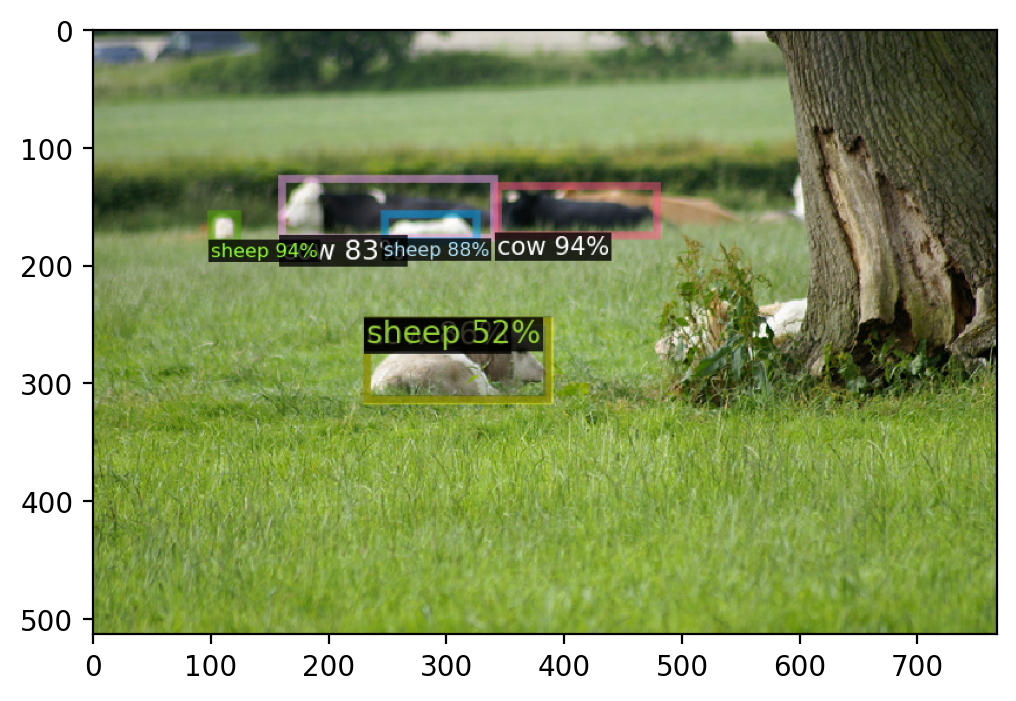

In [7]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(original_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Export the model as onnx

Detectron2 already provides a script to export onnx models, use it with:

```sh
./tools/deploy/export_model.py --config-file configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml \
    --output ./output \
    --export-method caffe2_tracing \
    --format onnx \
    MODEL.WEIGHTS detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl \
    MODEL.DEVICE cpu
```

The following steps show how the onnx tracing is done.

In [8]:
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

from detectron2.export import Caffe2Tracer

from torchvision.transforms import transforms

import onnx

In [9]:
# build the model with the config used before
torch_model = build_model(cfg)
DetectionCheckpointer(torch_model).resume_or_load(cfg.MODEL.WEIGHTS)
torch_model.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [10]:
# https://github.com/facebookresearch/detectron2/blob/master/tools/deploy/export_model.py#L45
from detectron2.data import build_detection_test_loader

# get a sample data
data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
first_batch = next(iter(data_loader))

# https://github.com/facebookresearch/detectron2/blob/master/tools/deploy/export_model.py#L45
tracer = Caffe2Tracer(
    cfg, 
    torch_model, 
    first_batch
)

onnx_model = tracer.export_onnx()
onnx.save(onnx_model, "model.onnx")

[03/18 19:26:47 d2.data.datasets.coco]: Loaded 100 images in COCO format from datasets/coco/annotations/instances_val2017.json
[03/18 19:26:47 d2.data.build]: Distribution of instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 341          |   bicycle    | 10           |      car      | 51           |
|  motorcycle   | 23           |   airplane   | 0            |      bus      | 10           |
|     train     | 2            |    truck     | 4            |     boat      | 13           |
| traffic light | 9            | fire hydrant | 5            |   stop sign   | 1            |
| parking meter | 0            |    bench     | 14           |     bird      | 13           |
|      cat      | 2            |     dog      | 4            |     horse     | 5            |
|     sheep     | 0            |     c

/home/users/fassbinb/.local/lib/python3.8/site-packages/torch/onnx/utils.py:262: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  warnings.warn("`{}' can be set to True only when 'operator_export_type' is "
/home/users/fassbinb/.local/lib/python3.8/site-packages/torch/onnx/utils.py:262: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  warnings.warn("`{}' can be set to True only when 'operator_export_type' is "
/home/users/fassbinb/Work/detectron2/detectron2/export/c10.py:31: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace mig

In [11]:
# the model can be loaded using the Caffe2 backend (optimized for cpu inference) and
# do predicions without detectron2
import caffe2.python.onnx.backend as backend

model = onnx.load("model.onnx")  # or use the `onnx_model` from above
onnx.checker.check_model(model)

# To print a human readable representation of the graph use:
print(onnx.helper.printable_graph(model.graph))

graph torch-jit-export (
  %data[UINT8, 1x3x800x1216]
  %im_info[FLOAT, 1x3]
) optional inputs with matching initializers (
  %_wrapped_model.backbone.fpn_lateral2.weight[FLOAT, 256x256x1x1]
  %_wrapped_model.backbone.fpn_lateral2.bias[FLOAT, 256]
  %_wrapped_model.backbone.fpn_output2.weight[FLOAT, 256x256x3x3]
  %_wrapped_model.backbone.fpn_output2.bias[FLOAT, 256]
  %_wrapped_model.backbone.fpn_lateral3.weight[FLOAT, 256x512x1x1]
  %_wrapped_model.backbone.fpn_lateral3.bias[FLOAT, 256]
  %_wrapped_model.backbone.fpn_output3.weight[FLOAT, 256x256x3x3]
  %_wrapped_model.backbone.fpn_output3.bias[FLOAT, 256]
  %_wrapped_model.backbone.fpn_lateral4.weight[FLOAT, 256x1024x1x1]
  %_wrapped_model.backbone.fpn_lateral4.bias[FLOAT, 256]
  %_wrapped_model.backbone.fpn_output4.weight[FLOAT, 256x256x3x3]
  %_wrapped_model.backbone.fpn_output4.bias[FLOAT, 256]
  %_wrapped_model.backbone.fpn_lateral5.weight[FLOAT, 256x2048x1x1]
  %_wrapped_model.backbone.fpn_lateral5.bias[FLOAT, 256]
  %_wrapped_

In [12]:
from detectron2.export.caffe2_modeling import convert_batched_inputs_to_c2_format, META_ARCH_CAFFE2_EXPORT_TYPE_MAP

# image preparation from `DefaultPredictor`
# https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/defaults.py#L214
original_image = cv2.imread('datasets/coco/val2017/000000023937.jpg')

aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
)

height, width = original_image.shape[:2]
image = aug.get_transform(original_image).apply_image(original_image)
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

inputs = {"image": image, "height": height, "width": width}
(image, img_info) = convert_batched_inputs_to_c2_format([inputs], 32, "cpu")

In [13]:
print(model.graph.input[0])
print(model.graph.input[1])

# two inputs are needed `data` wich is the image and `img_info` wich represents the shape of the image
W = {
    model.graph.input[0].name: image.data.numpy(),
    model.graph.input[1].name: img_info.data.numpy()
}

name: "data"
type {
  tensor_type {
    elem_type: 2
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 800
      }
      dim {
        dim_value: 1216
      }
    }
  }
}

name: "im_info"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 3
      }
    }
  }
}



In [14]:
# run onnx inference
rep = backend.prepare(model)
raw_onnx_outputs = rep.run(W)

/home/users/fassbinb/.local/lib/python3.8/site-packages/caffe2/python/onnx/backend.py:690: UserWarning: Unrecognized operator set org.pytorch._caffe2
  warnings.warn("Unrecognized operator set {}".format(imp.domain))


In [15]:
onnx_outputs = {
    "bbox_nms": torch.tensor(raw_onnx_outputs.roi_bbox_nms),
    "score_nms": torch.tensor(raw_onnx_outputs._1),
    "class_nms": torch.tensor(raw_onnx_outputs._2)
}

In [16]:
# convert output to detectron2 compatible output
from detectron2.modeling import meta_arch
from detectron2.export.caffe2_modeling import assemble_rcnn_outputs_by_name

image_sizes = [[int(im[0]), int(im[1])] for im in img_info]
results = assemble_rcnn_outputs_by_name(image_sizes, onnx_outputs)

# replace with the used model
outputs = getattr(meta_arch, cfg.MODEL.META_ARCHITECTURE)._postprocess(results, [inputs], image_sizes)

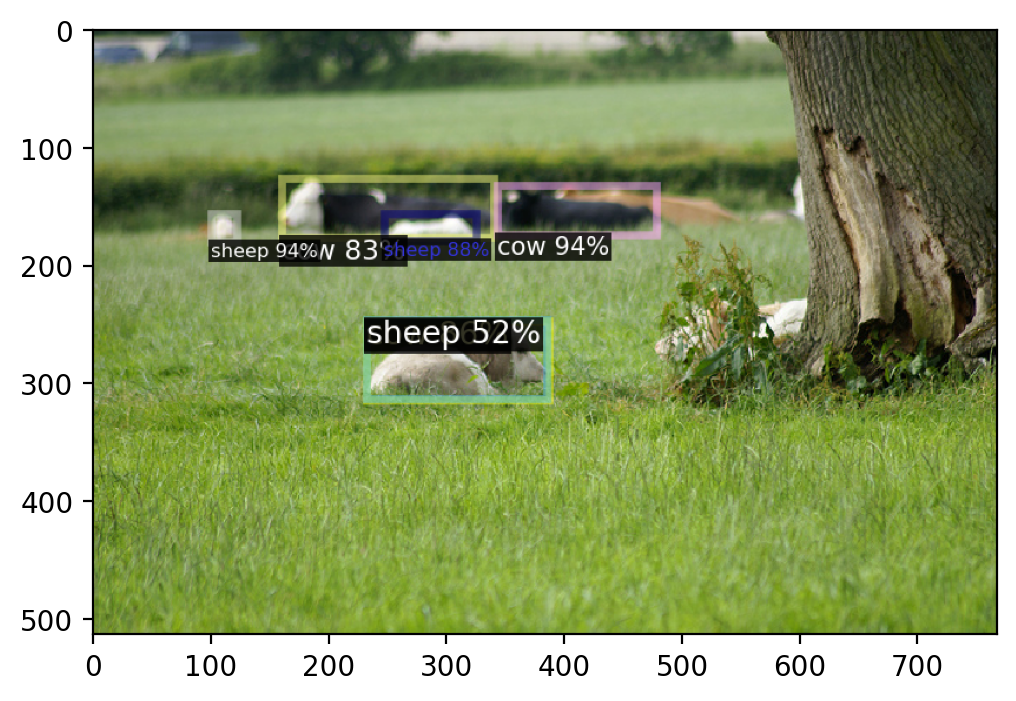

In [17]:
v = Visualizer(original_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])